# Import some modules

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.image as mpimg

# Test one picture

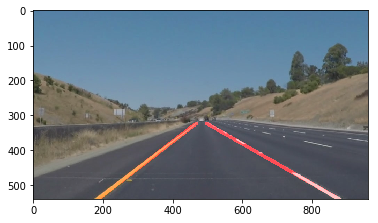

In [46]:
import processImage
import matplotlib.pyplot as plt

image_path='/Users/zengxuefeng/Development/LaneLinesDetection/test_images/whiteCarLaneSwitch.jpg'

img=processImage.detect(mpimg.imread(image_path))
plt.imshow(img)


# Test all picture

Save:  test_images/test_output/solidWhiteCurve.jpg OK!
Save:  test_images/test_output/solidWhiteRight.jpg OK!
Save:  test_images/test_output/solidYellowCurve.jpg OK!
Save:  test_images/test_output/solidYellowCurve2.jpg OK!
Save:  test_images/test_output/solidYellowLeft.jpg OK!
Save:  test_images/test_output/whiteCarLaneSwitch.jpg OK!


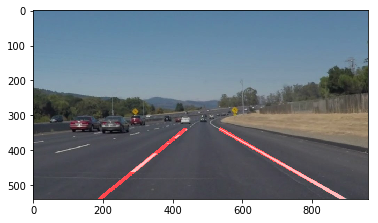

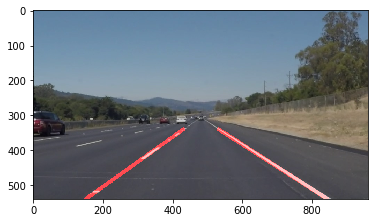

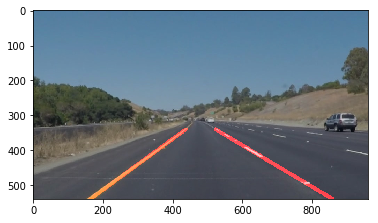

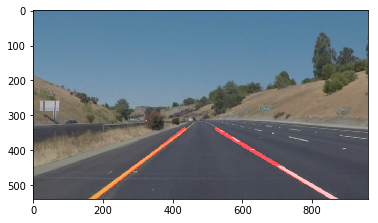

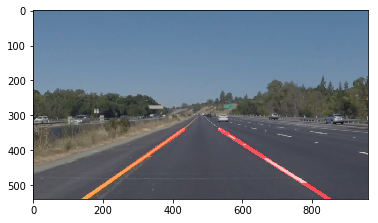

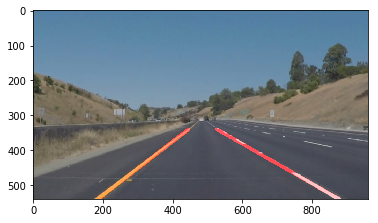

In [25]:
import imghdr
import os
import matplotlib.pyplot as plt
import matplotlib
import processImage

dir="test_images/"
file_names=os.listdir("test_images/")
for n in file_names:
    des_file=dir+n
    if(os.path.isfile(des_file) and imghdr.what(des_file)=='jpeg'):
        output_image=processImage.detect(mpimg.imread(des_file))
        save_path=dir+"test_output/"+n
        plt.imsave(save_path,output_image)
        print('Save:  '+save_path +' OK!')
        plt.figure()
        plt.imshow(output_image)

# Test video

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import processImage

### Video 1

In [68]:
vedio_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
processImage.clearHistory()
white_clip = clip1.fl_image(lambda x: processImage.detect(x,True)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(vedio_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vedio_output))


[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:10<00:00, 21.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 6.81 s, sys: 1.43 s, total: 8.24 s
Wall time: 11.6 s


### Video 2

In [69]:
vedio_output = 'yellow.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")
processImage.clearHistory()
white_clip = clip1.fl_image(lambda x: processImage.detect(x,True)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(vedio_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vedio_output))

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:33<00:00, 20.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 21.6 s, sys: 4.33 s, total: 25.9 s
Wall time: 34.9 s


### Video "challenge.mp4"

In [71]:
vedio_output = 'extra.mp4'
clip1 = VideoFileClip("challenge.mp4")
processImage.clearHistory()
white_clip = clip1.fl_image(lambda x: processImage.detect(x,True)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(vedio_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vedio_output))

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:24<00:00, 10.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 19.8 s, sys: 3.09 s, total: 22.9 s
Wall time: 27.4 s
